In [1]:
!pip install -r /mnt/c/Users/santhosh/Downloads/MedMamba-main/MedMamba-main/requirements.txt


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [15]:
import sys
sys.path.append('/mnt/c/Users/santhosh/Downloads/MedMamba-main')


In [ ]:
import importlib.util
import sys

module_name = 'MedMamba'
module_path = '/path/to/Medmamba.py'

spec = importlib.util.spec_from_file_location(module_name, module_path)
medmamba = importlib.util.module_from_spec(spec)
sys.modules[module_name] = medmamba
spec.loader.exec_module(medmamba)

In [32]:
import os
import sys
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from tqdm import tqdm
from MedMamba import VSSM as medmamba  # Import MedMamba model
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Learning Rate Scheduler
from torch.utils.data import random_split, DataLoader

class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        # Load Pretrained EfficientNetB0
        self.efficient_net = models.efficientnet_b0(pretrained=True)
        
        # Remove the final classification layer
        self.efficient_net.classifier = nn.Identity()
        
        # Load Medmamba Model
        self.medmamba_model = medmamba(num_classes=num_classes)

        # Define a new classifier combining both models
        self.classifier = nn.Sequential(
            nn.Linear(1000 + 285, 512),  # Combining EfficientNet & Medmamba outputs
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)  # Final classification layer
        )

    def forward(self, x):
        eff_out = self.efficient_net(x)
        med_out = self.medmamba_model(x)
        combined_out = torch.cat((eff_out, med_out), dim=1) 

        return self.classifier(combined_out)

# Initialize the new model
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using {device} device.")

    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# Load full dataset
    dataset = datasets.ImageFolder(root="/mnt/c/Users/santhosh/Downloads/MedMamba-main/training", transform=data_transform)

# Split dataset into train, validation, and test sets
    train_size = int(0.7 * len(dataset))   # 70% for training
    val_size = int(0.15 * len(dataset))    # 15% for validation
    test_size = len(dataset) - train_size - val_size  # 15% for testing

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    print(f"Training Samples: {len(train_dataset)}, Validation Samples: {len(val_dataset)},test samples: {len(test_dataset)}")

    batch_size = 8
    num_classes = len(dataset.classes)  # Automatically detect number of classes

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Load Model
    net = CombinedModel(num_classes=num_classes)
    net.to(device)

    # Loss and Optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    # Learning Rate Scheduler (Reduces LR if val_accuracy plateaus)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=True)

    # Early Stopping Parameters
    early_stop_patience = 10
    no_improvement_epochs = 0

    # Training loop
    epochs = 100
    best_acc = 0.0
    save_path = 'EfficientMedMambaNet2.pth'
    torch.cuda.empty_cache()

    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, file=sys.stdout)

        for step, data in enumerate(train_bar):
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # Move to GPU

            optimizer.zero_grad()
            outputs = net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_bar.set_description(f"Epoch [{epoch+1}/{epochs}] Loss: {loss:.4f}")

        # Validation
        net.eval()
        acc = 0.0
        with torch.no_grad():
            val_bar = tqdm(val_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                outputs = net(val_images)
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels).sum().item()

        val_accurate = acc / len(val_dataset)
        print(f"[Epoch {epoch+1}] Train Loss: {running_loss / len(train_loader):.4f}  Val Accuracy: {val_accurate:.4f}")

        # Reduce LR if validation accuracy doesn't improve
        scheduler.step(val_accurate)

        # Check for Early Stopping
        if val_accurate > best_acc:
            best_acc = val_accurate
            no_improvement_epochs = 0  # Reset counter
            torch.save(net.state_dict(), save_path)
        else:
            no_improvement_epochs += 1  # Increment counter

        if no_improvement_epochs >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in validation accuracy.")
            break  # Stop training

    print("Finished Training")

if __name__ == '__main__':
    main()


Using cuda:0 device.
Training Samples: 2559, Validation Samples: 548,test samples: 549


/home/santhosh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/santhosh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


100%|██████████| 69/69 [00:05<00:00, 13.13it/s]
[Epoch 1] Train Loss: 0.7977  Val Accuracy: 0.8157
100%|██████████| 69/69 [00:05<00:00, 13.59it/s]
[Epoch 2] Train Loss: 0.5798  Val Accuracy: 0.8303
100%|██████████| 69/69 [00:05<00:00, 13.70it/s]
[Epoch 3] Train Loss: 0.4889  Val Accuracy: 0.8467
100%|██████████| 69/69 [00:05<00:00, 13.73it/s]
[Epoch 4] Train Loss: 0.4117  Val Accuracy: 0.8504
100%|██████████| 69/69 [00:05<00:00, 13.73it/s]
[Epoch 5] Train Loss: 0.3482  Val Accuracy: 0.8011
100%|██████████| 69/69 [00:05<00:00, 13.34it/s]
[Epoch 6] Train Loss: 0.2448  Val Accuracy: 0.8139
100%|██████████| 69/69 [00:05<00:00, 13.73it/s]
[Epoch 7] Train Loss: 0.2243  Val Accuracy: 0.8321
100%|██████████| 69/69 [00:05<00:00, 13.47it/s]
[Epoch 8] Train Loss: 0.1880  Val Accuracy: 0.8321
100%|██████████| 69/69 [00:05<00:00, 13.40it/s]
[Epoch 9] Train Loss: 0.1215  Val Accuracy: 0.8230
100%|██████████| 69/69 [00:05<00:00, 13.64it/s]
[Epoch 10] Train Loss: 0.1275  Val Accuracy: 0.8212
Epoch 000

In [33]:
import torch
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from MedMamba import VSSM as medmamba  # Import your MedMamba model

# Define transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load full dataset
dataset = datasets.ImageFolder(root="/mnt/c/Users/santhosh/Downloads/MedMamba-main/training", transform=data_transform)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))   # 70% for training
val_size = int(0.15 * len(dataset))    # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get number of classes
num_classes = len(dataset.classes)
class_names = dataset.classes

# Define Combined Model
class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        # Load Pretrained EfficientNetB0
        self.efficient_net = models.efficientnet_b0(pretrained=True)
        
        # Remove the final classification layer
        self.efficient_net.classifier = nn.Identity()
        
        # Load Medmamba Model
        self.medmamba_model = medmamba(num_classes=num_classes)

        # Define a new classifier combining both models
        self.classifier = nn.Sequential(
            nn.Linear(1000 + 285, 512),  # Combining EfficientNet & Medmamba outputs
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)  # Final classification layer
        )

    def forward(self, x):
        eff_out = self.efficient_net(x)
        med_out = self.medmamba_model(x)
        combined_out = torch.cat((eff_out, med_out), dim=1) 

        return self.classifier(combined_out)


# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the saved model
model = CombinedModel(num_classes=num_classes)  # Use correct number of classes
model.load_state_dict(torch.load("/mnt/c/Users/santhosh/Downloads/MedMamba-main/MedMamba-main/EfficientMedMambaNet2.pth"))
model.to(device)
model.eval()

# Use Test Loader for Evaluation
test_loader = test_loader  # Using test dataset instead of validation

print(f"Data split: {train_size} train, {val_size} val, {test_size} test")


Data split: 2559 train, 548 val, 549 test


In [36]:
# Compute Training Accuracy
train_correct = 0
train_total = 0

with torch.no_grad():
    for images, labels in train_loader:  # Use train_loader instead of test_loader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # Get predictions
        preds = torch.max(outputs, dim=1)[1]
        
        # Update total and correct counts
        train_total += labels.size(0)
        train_correct += (preds == labels).sum().item()

# Compute accuracy
train_accuracy = 100 * train_correct / train_total
print(f"Training Accuracy: {train_accuracy:.2f}%")


Training Accuracy: 91.44%


In [37]:
import numpy as np

# Initialize metrics
all_labels = []
all_preds = []
total_loss = 0.0
loss_function = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Compute loss
        loss = loss_function(outputs, labels)
        total_loss += loss.item()

        # Get predictions
        preds = torch.max(outputs, dim=1)[1]
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Compute accuracy
accuracy = np.mean(all_preds == all_labels)

# Compute precision, recall, F1-score for each class
precision = precision_score(all_labels, all_preds, average=None, labels=range(num_classes))
recall = recall_score(all_labels, all_preds, average=None, labels=range(num_classes))
f1 = f1_score(all_labels, all_preds, average=None, labels=range(num_classes))

# Compute overall metrics (macro-average)
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro = recall_score(all_labels, all_preds, average='macro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

print(f"Test Loss: {total_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (per class): {precision}")
print(f"Recall (per class): {recall}")
print(f"F1-score (per class): {f1}")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")
print(f"F1-score (macro): {f1_macro:.4f}")


Test Loss: 0.2890
Test Accuracy: 88.71%
Precision (per class): [0.8125     0.78666667 0.99300699 0.73809524 0.65217391]
Recall (per class): [0.69642857 0.90076336 0.98611111 0.65957447 0.55555556]
F1-score (per class): [0.75       0.83985765 0.98954704 0.69662921 0.6       ]
Precision (macro): 0.7965
Recall (macro): 0.7597
F1-score (macro): 0.7752


In [39]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt  # Importing matplotlib to show the image

# Function to load and predict
def predict_image_class(image_path, model, device):
    # Load the image
    img = Image.open(image_path)
    
    # Define the same transformations as during training
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    
    # Apply transformations
    image = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Ensure the model is on the same device as the input
    model.to(device)

    # Perform inference
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)  # Get the predicted class
    
    # Define your class labels
    predictions = ["Mild", "Moderate", "NO_DR", "Proliferate_DR", "Severe"]
    
    # Get the predicted class
    predicted_class = predictions[pred.item()]

    # Display the image with the prediction
    plt.imshow(img)
    plt.axis('off')  # Turn off the axis
    plt.title(f"Prediction: {predicted_class}")
    plt.show()

    # Print the predicted class
    print(f"Predicted class: {predicted_class}")

# Get the device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

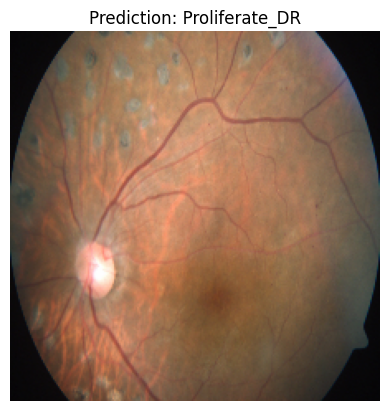

Predicted class: Proliferate_DR


In [40]:
image_path = '/mnt/c/Users/santhosh/Downloads/MedMamba-main/training/Proliferate_DR/2fe06bedb2c4.png' # Replace with your image path
predict_image_class(image_path, model, device)

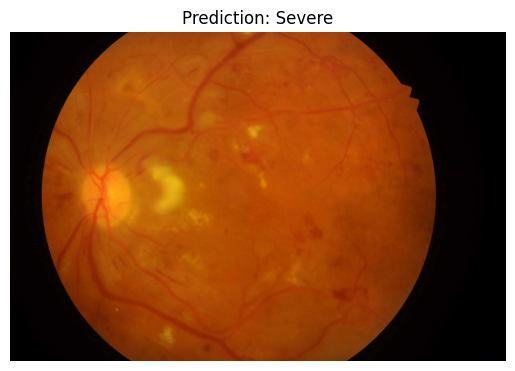

Predicted class: Severe


In [41]:
image_path = '/mnt/c/Users/santhosh/Downloads/MedMamba-main/image (1).jpg' # Replace with your image path
predict_image_class(image_path, model, device)

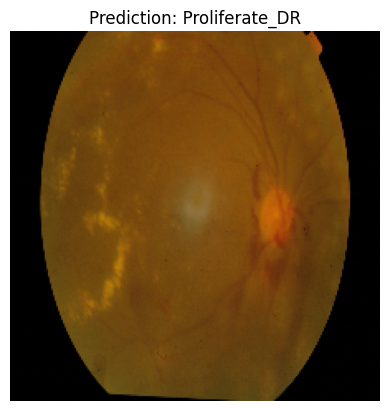

Predicted class: Proliferate_DR


In [17]:
image_path = '/mnt/c/Users/santhosh/Downloads/MedMamba-main/training/Proliferate_DR/1b32e1d775ea.png' # Replace with your image path
predict_image_class(image_path, model, device)

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from MedMamba import VSSM as medmamba  # Import your MedMamba model

# Define transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define Class Names (Update Based on Your Dataset)
class_names = ["Mild DR", "Moderate DR","No DR","Proliferative DR", "Severe DR"]


# Define Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activation = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, class_idx):
        grads = self.gradients
        pooled_grads = torch.mean(grads, dim=[0, 2, 3])
        for i in range(self.activation.shape[1]):
            self.activation[:, i, :, :] *= pooled_grads[i]
        heatmap = torch.mean(self.activation, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)
        return heatmap.cpu().detach().numpy()



# Attach Grad-CAM to EfficientNet last convolutional layer
gradcam = GradCAM(model.efficient_net.features[-1], model.efficient_net.features[-1][0])

# Function to predict class and explain decision
def predict_and_explain(image_path, model, gradcam):
    image = Image.open(image_path).convert("RGB")
    input_tensor = data_transform(image).unsqueeze(0).to(device)

    # Forward pass
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()
    class_name = class_names[predicted_class]

    # Generate Grad-CAM heatmap
    output[:, predicted_class].backward()
    heatmap = gradcam.generate_cam(predicted_class)
    heatmap = cv2.resize(heatmap, (224, 224))

    # Convert PIL image to numpy array
    image_np = np.array(image.resize((224, 224)))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

    # Display results
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[1].imshow(heatmap)
    ax[1].set_title("Grad-CAM Heatmap")
    ax[2].imshow(overlay)
    ax[2].set_title(f"Overlay - {class_name}")
    plt.show()

    # Generate textual explanation based on Grad-CAM heatmap
    explanation = f"The image is classified as '{class_name}' because the model detected features associated with this condition in the highlighted regions (shown in the heatmap). These regions indicate areas of interest that influenced the model's decision."

    if predicted_class == 0:
        explanation += " There are no significant abnormalities in the fundus image, suggesting a healthy retina. The model focused on the overall uniform texture of the retina."
    elif predicted_class == 1:
        explanation += " The model detected mild signs of diabetic retinopathy, such as small microaneurysms. The highlighted regions correspond to areas where these features are visible."
    elif predicted_class == 2:
        explanation += " Moderate diabetic retinopathy was identified, characterized by more widespread microaneurysms and hemorrhages. The heatmap highlights regions with these abnormalities."
    elif predicted_class == 3:
        explanation += " The model observed severe DR indicators, including larger hemorrhages and exudates. The highlighted areas correspond to these larger, more prominent features."
    elif predicted_class == 4:
        explanation += " Proliferative diabetic retinopathy was detected, with abnormal blood vessel growth and high-risk lesions. The highlighted regions reflect these dangerous features."

    print("\nPrediction:", class_name)
    print("Explanation:", explanation)




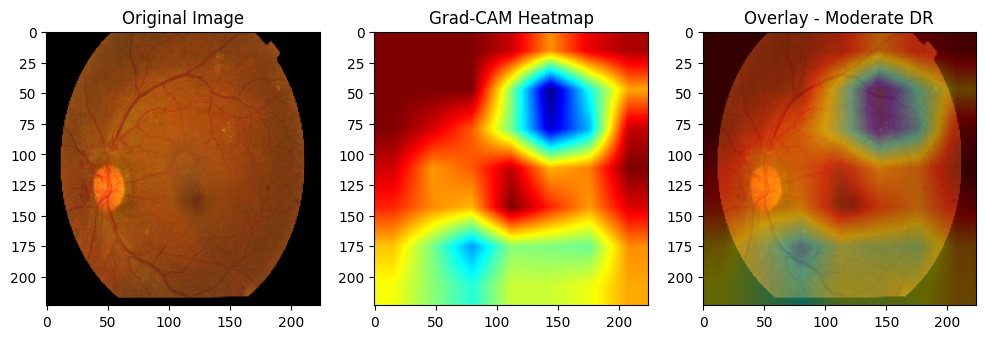


Prediction: Moderate DR
Explanation: The image is classified as 'Moderate DR' because the model detected features associated with this condition in the highlighted regions (shown in the heatmap). These regions indicate areas of interest that influenced the model's decision. The model detected mild signs of diabetic retinopathy, such as small microaneurysms. The highlighted regions correspond to areas where these features are visible.


In [ ]:
image_path = "/mnt/c/Users/santhosh/Downloads/MedMamba-main/training/Proliferate_DR/1fd5d860d4d7.png"
predict_and_explain(image_path, model, gradcam)

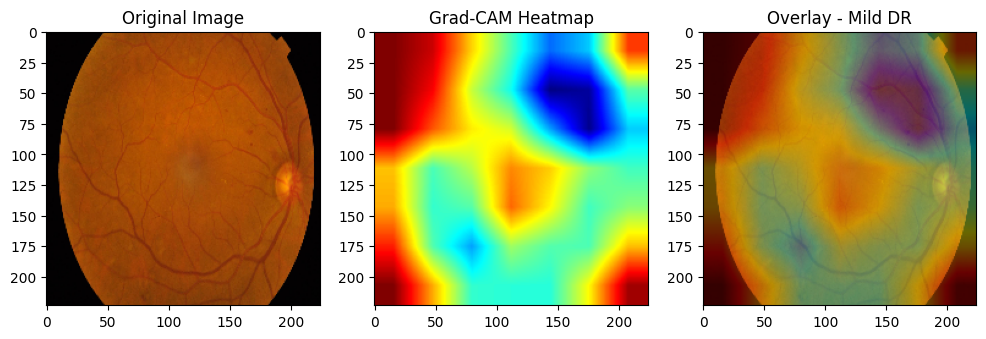


Prediction: Mild DR
Explanation: The image is classified as 'Mild DR' because the model detected features associated with this condition in the highlighted regions (shown in the heatmap). These regions indicate areas of interest that influenced the model's decision. There are no significant abnormalities in the fundus image, suggesting a healthy retina. The model focused on the overall uniform texture of the retina.


In [49]:
image_path = "/mnt/c/Users/santhosh/Downloads/MedMamba-main/training/Mild/1df3e03a8f5f.png"
predict_and_explain(image_path, model, gradcam)

In [50]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to calculate gradients
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Calculate Training Accuracy
train_accuracy = evaluate_model(model, train_loader, device)
print(f"Training Accuracy: {train_accuracy:.2f}%")


Training Accuracy: 91.44%


In [51]:
criterion = nn.CrossEntropyLoss() 
def compute_loss(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():  # No need for gradient calculation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # Compute batch loss
            total_loss += loss.item() * labels.size(0)  # Multiply by batch size
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples  # Compute average loss
    return avg_loss

# Compute Training Loss
train_loss = compute_loss(model, train_loader, criterion, device)
print(f"Training Loss: {train_loss:.4f}")


Training Loss: 0.2634
